In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import shap

nba_stats = pd.read_csv('nba_team_data.csv')
nba_stats = nba_stats.dropna()
#Create feature columns
exclude_columns = ['season', 'name', 'conference', 'Champion_Win_Share']
feature_columns = [col for col in nba_stats.columns if col not in exclude_columns]

random_seed = 12345
random.seed(random_seed)

#Split by randomly selecting 2 Seasons each decade and save in train_set and test_set
nba_stats['season'] = nba_stats['season'].astype(str)
nba_stats['Decade'] = nba_stats['season'].apply(lambda x: x[:3] + '0')
unique_decades = nba_stats['Decade'].unique()
train_set = pd.DataFrame()
test_set = pd.DataFrame()
for decade in unique_decades:
    decade_data = nba_stats[nba_stats['Decade'] == decade]
    
    # Randomly select two seasons for the test set
    test_seasons = random.sample(list(decade_data['season']), k=2)
    test_set = pd.concat([test_set, decade_data[decade_data['season'].isin(test_seasons)]])
    train_set = pd.concat([train_set, decade_data[~decade_data['season'].isin(test_seasons)]])

train_set = train_set.drop(columns=['Decade'])
test_set = test_set.drop(columns=['Decade'])

test_seasons = test_set['season'].unique()

#Create the feature and target sets
X_train = train_set[feature_columns]
y_train = train_set['Champion_Win_Share']
X_test = test_set[feature_columns]
y_test = test_set['Champion_Win_Share']


# Set random seed for models
random_seed = 6789
random.seed(random_seed)

xgb_model = XGBRegressor(random_state=random_seed)
xgb_model.fit(X_train, y_train)

rf_model = RandomForestRegressor(random_state=random_seed)
rf_model.fit(X_train, y_train)

xgb_predictions = xgb_model.predict(X_test)
rf_predictions = rf_model.predict(X_test)

test_set['XGB_Predicted_Champion'] = xgb_predictions
test_set['RF_Predicted_Champion'] = rf_predictions

xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_predictions))
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_predictions))

print("XGBoost Mean Squared error:")
print(xgb_rmse)
print("Random Forest Mean Squared error:")
print(rf_rmse)

for season in test_seasons:
    print(f"\nResults for {season} Season:")
    
    xgb_output = test_set[(test_set['season'] == str(season))][['name', 'XGB_Predicted_Champion','Champion_Win_Share']].sort_values(by='XGB_Predicted_Champion', ascending=False).head(8)
    print("XGBoost Predictions:")
    print(xgb_output)
    
    rf_output = test_set[(test_set['season'] == str(season))][['name', 'RF_Predicted_Champion','Champion_Win_Share']].sort_values(by='RF_Predicted_Champion', ascending=False).head(8)
    print("\nRandom Forest Predictions:")
    print(rf_output)

# Visualization
plt.scatter(y_test, xgb_predictions, label="XGBoost Predictions")
plt.scatter(y_test, rf_predictions, label="Random Forest Predictions")
plt.xlabel("Actual Champion_Win_Share")
plt.ylabel("Predicted Champion_Win_Share")
plt.legend()
plt.show()

# Explain XGBoost predictions with SHAP
explainer_xgb = shap.Explainer(xgb_model)
shap_values_xgb = explainer_xgb.shap_values(X_test)

# Explain Random Forest predictions with SHAP
explainer_rf = shap.Explainer(rf_model)
shap_values_rf = explainer_rf.shap_values(X_test)

# Summary plot for XGBoost
shap.summary_plot(shap_values_xgb, X_test, feature_names=feature_columns, plot_type="bar", show=False, max_display=10)

fig = plt.gcf()
fig.set_size_inches(10, 6)
plt.title("Shap Importance XGB", fontsize=14, loc="center")   
plt.tight_layout()
plt.show()

# Summary plot for Random Forest
shap.summary_plot(shap_values_rf, X_test, feature_names=feature_columns, plot_type="bar", show=False, max_display=10)

fig = plt.gcf()
fig.set_size_inches(10, 6)
plt.title("Shap Importance RF", fontsize=14, loc="center")   
plt.tight_layout()
plt.show()



array([0.        , 0.        , 0.19920833, 0.63745833, 0.        ,
       0.        , 0.        , 0.        , 0.23479167, 0.        ,
       0.19154167, 0.        , 0.28375   , 0.23229167, 0.        ,
       0.        , 0.50433333, 0.        , 0.14208333, 0.4455    ,
       0.        , 0.72154167, 0.        , 0.59829167, 0.29091667,
       0.23108333, 0.53270833, 0.44658333, 0.        , 0.17066667,
       0.55016667, 0.322625  , 0.53029167, 0.18308333, 0.501125  ,
       0.        , 0.        , 0.65091667, 0.45733333, 0.36579167,
       0.18441667, 0.22925   , 0.        , 0.        , 0.006875  ,
       0.26066667, 0.21275   , 0.        , 0.53254167, 0.5755    ,
       0.        , 0.        , 0.        , 0.22379167, 0.        ,
       0.        , 0.214875  , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.20470833, 0.118375  , 0.        ,
       0.17575   , 0.48633333, 0.16170833, 0.        , 0.76845833,
       0.17183333, 0.16583333, 0.00133333, 0.613875  , 0.65766


Results for Season 2021:
XGBoost Predictions:
                      name  XGB_Predicted_Champion  Champion_Win_Share
37      Philadelphia 76ers                0.667144              0.4375
34              Miami Heat                0.629226              0.0000
38          Denver Nuggets                0.467003              0.2500
49               Utah Jazz                0.438594              0.3750
30            Phoenix Suns                0.429755              0.8750
48         Milwaukee Bucks                0.412553              1.0000
45        Dallas Mavericks                0.395357              0.1875
32           Brooklyn Nets                0.380971              0.4375
31    Los Angeles Clippers                0.328904              0.6250
39      Los Angeles Lakers                0.313250              0.1250
41          Boston Celtics                0.226295              0.0625
56  Portland Trail Blazers                0.168949              0.1250
53           Atlanta Hawks    

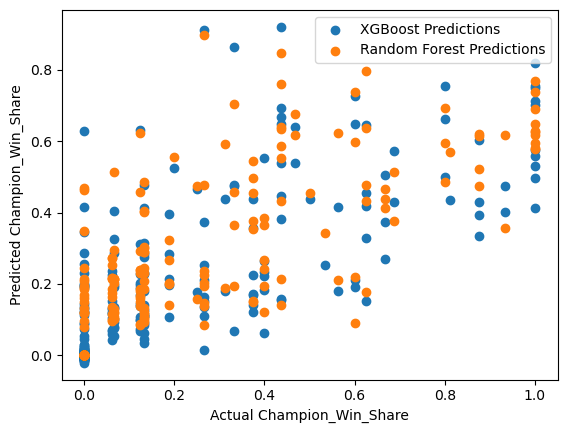

In [2]:
season = 2021
print(f"\nResults for Season {season}:")

xgb_output = test_set[(test_set['season'] == str(season))][['name', 'XGB_Predicted_Champion','Champion_Win_Share']].sort_values(by='XGB_Predicted_Champion', ascending=False)
print("XGBoost Predictions:")
print(xgb_output)

rf_output = test_set[(test_set['season'] == str(season))][['name', 'RF_Predicted_Champion','Champion_Win_Share']].sort_values(by='RF_Predicted_Champion', ascending=False)
print("\nRandom Forest Predictions:")
print(rf_output)

# Visualization
plt.scatter(y_test, xgb_predictions, label="XGBoost Predictions")
plt.scatter(y_test, rf_predictions, label="Random Forest Predictions")
plt.xlabel("Actual Champion_Win_Share")
plt.ylabel("Predicted Champion_Win_Share")
plt.legend()
plt.show()


Results for Season 1991:
XGBoost Predictions:
                       name  XGB_Predicted_Champion  Champion_Win_Share
923          Boston Celtics                0.864477            0.333333
932      Los Angeles Lakers                0.661134            0.800000
930  Portland Trail Blazers                0.647009            0.600000
925         Detroit Pistons                0.639712            0.466667
912           Chicago Bulls                0.496557            1.000000
924            Phoenix Suns                0.403737            0.066667
929         Houston Rockets                0.287875            0.000000
933               Utah Jazz                0.251923            0.266667
917     Seattle SuperSonics                0.228083            0.133333
918      Philadelphia 76ers                0.209760            0.266667
934         New York Knicks                0.199024            0.000000
921       San Antonio Spurs                0.192252            0.066667
926           Atl

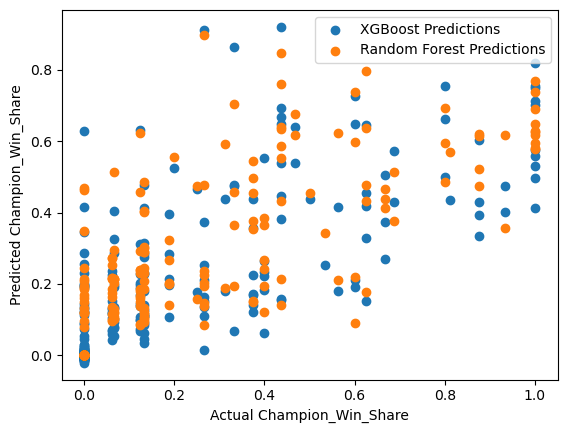

In [3]:
season = 1991
print(f"\nResults for Season {season}:")

xgb_output = test_set[(test_set['season'] == str(season))][['name', 'XGB_Predicted_Champion','Champion_Win_Share']].sort_values(by='XGB_Predicted_Champion', ascending=False)
print("XGBoost Predictions:")
print(xgb_output)

rf_output = test_set[(test_set['season'] == str(season))][['name', 'RF_Predicted_Champion','Champion_Win_Share']].sort_values(by='RF_Predicted_Champion', ascending=False)
print("\nRandom Forest Predictions:")
print(rf_output)

# Visualization
plt.scatter(y_test, xgb_predictions, label="XGBoost Predictions")
plt.scatter(y_test, rf_predictions, label="Random Forest Predictions")
plt.xlabel("Actual Champion_Win_Share")
plt.ylabel("Predicted Champion_Win_Share")
plt.legend()
plt.show()


Results for Season 1984:
XGBoost Predictions:
                        name  XGB_Predicted_Champion  Champion_Win_Share
1083          Boston Celtics                0.817955            1.000000
1082               Utah Jazz                0.476407            0.333333
1092      Los Angeles Lakers                0.475417            0.933333
1096      Philadelphia 76ers                0.412927            0.133333
1102  Portland Trail Blazers                0.314236            0.133333
1089         Milwaukee Bucks                0.254413            0.533333
1081         New York Knicks                0.222791            0.400000
1093            Phoenix Suns                0.212052            0.600000
1084       Kansas City Kings                0.190132            0.000000
1094           Atlanta Hawks                0.180869            0.133333
1090         Detroit Pistons                0.140015            0.133333
1088      Washington Bullets                0.102974            0.066667
1101

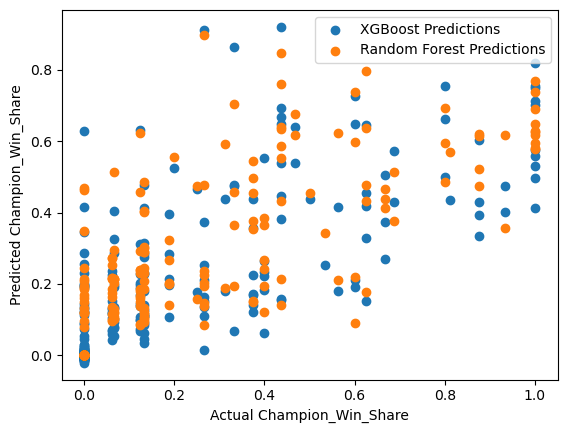

In [4]:
season = 1984
print(f"\nResults for Season {season}:")

xgb_output = test_set[(test_set['season'] == str(season))][['name', 'XGB_Predicted_Champion','Champion_Win_Share']].sort_values(by='XGB_Predicted_Champion', ascending=False)
print("XGBoost Predictions:")
print(xgb_output)

rf_output = test_set[(test_set['season'] == str(season))][['name', 'RF_Predicted_Champion','Champion_Win_Share']].sort_values(by='RF_Predicted_Champion', ascending=False)
print("\nRandom Forest Predictions:")
print(rf_output)

# Visualization
plt.scatter(y_test, xgb_predictions, label="XGBoost Predictions")
plt.scatter(y_test, rf_predictions, label="Random Forest Predictions")
plt.xlabel("Actual Champion_Win_Share")
plt.ylabel("Predicted Champion_Win_Share")
plt.legend()
plt.show()